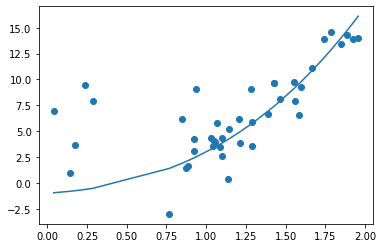

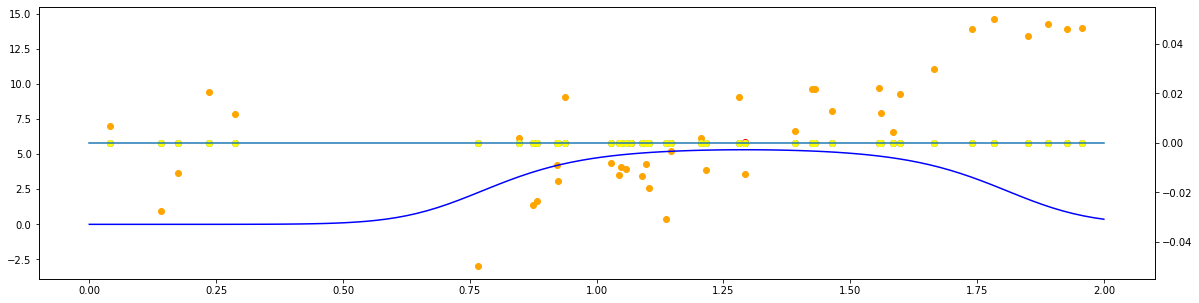

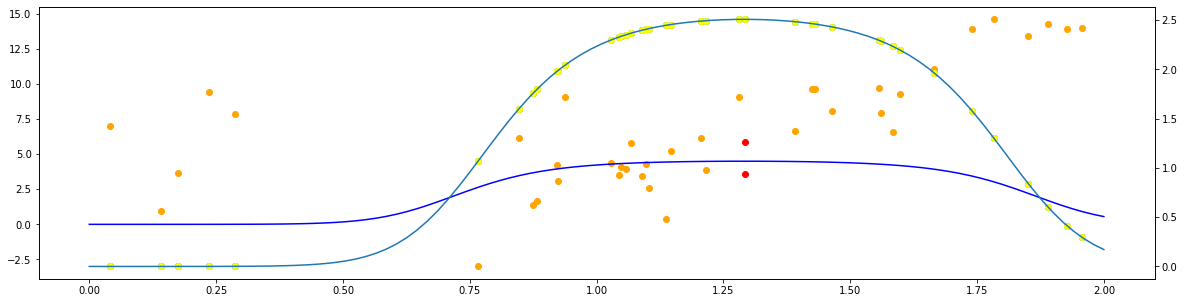

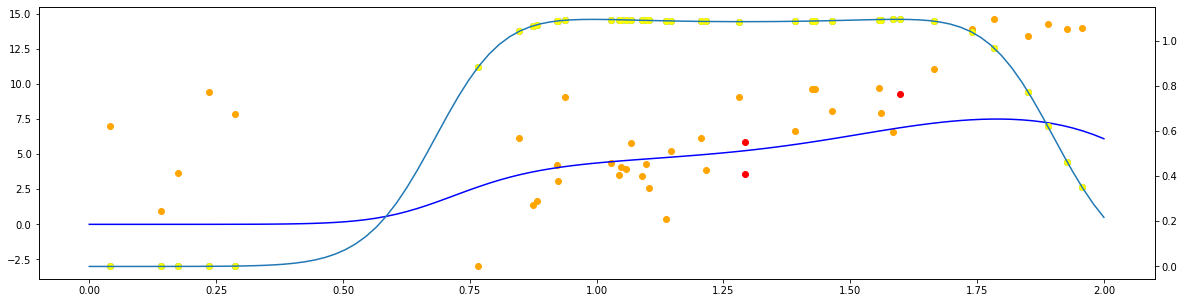

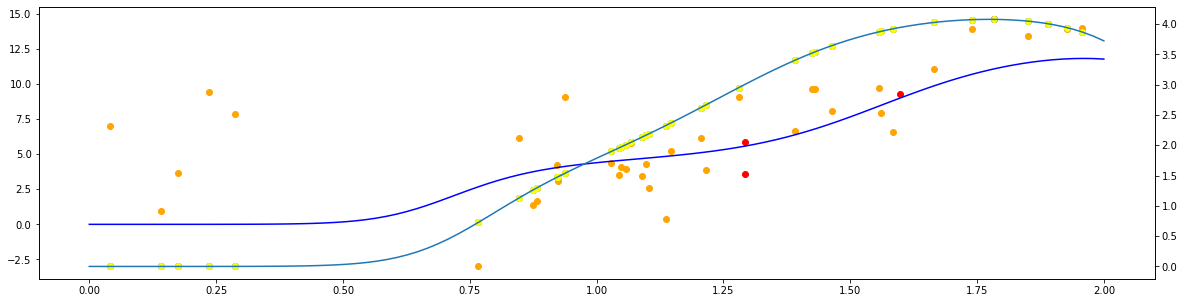

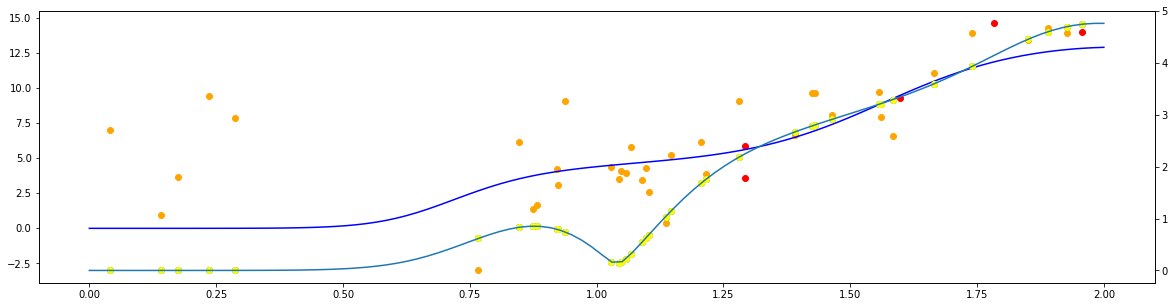

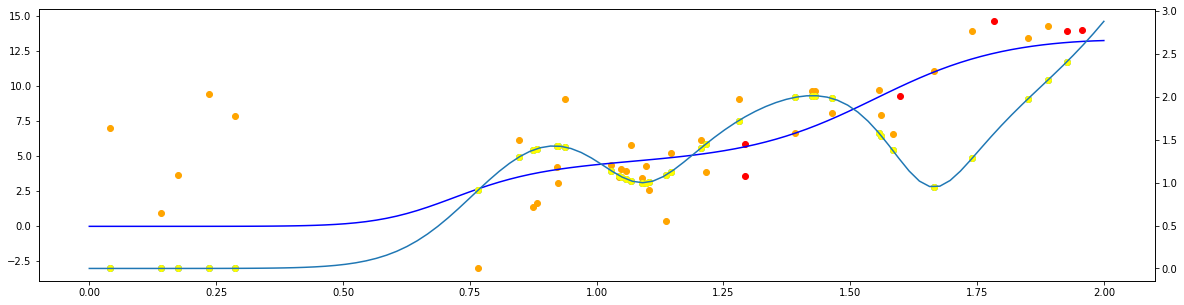

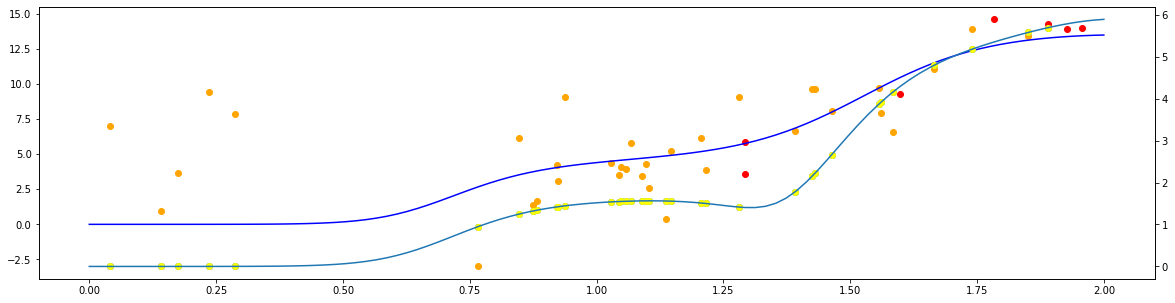

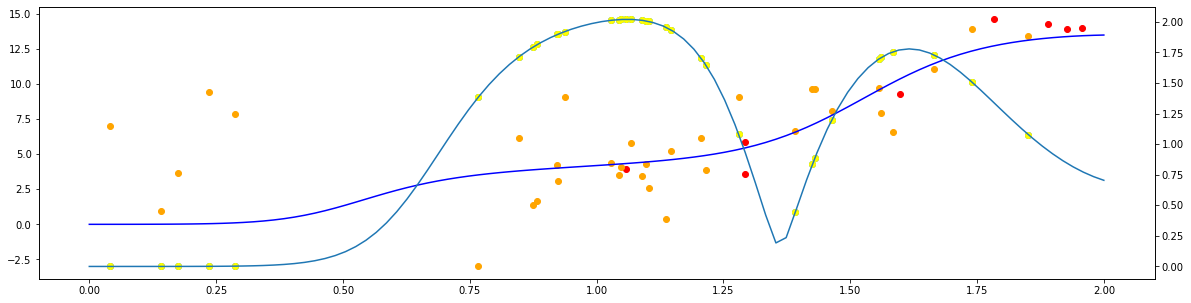

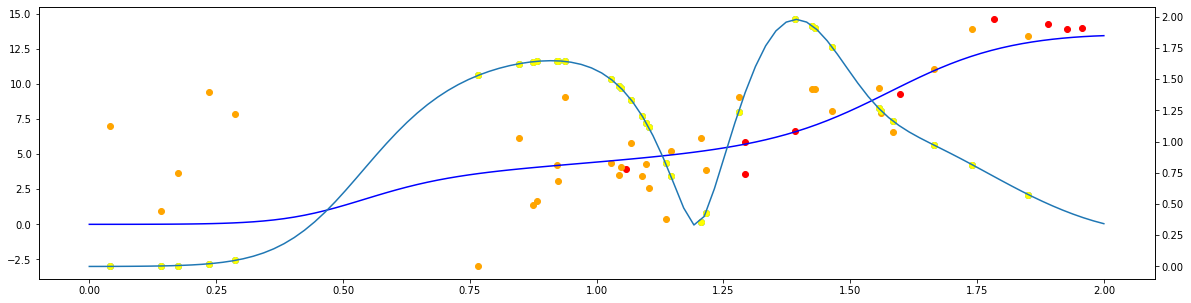

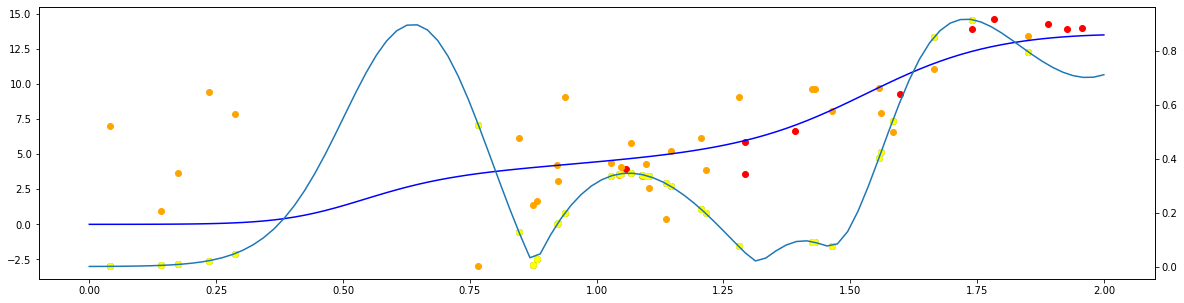

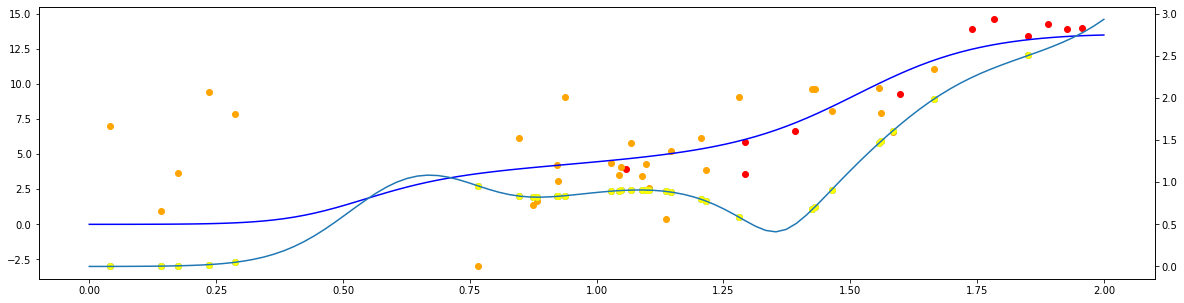

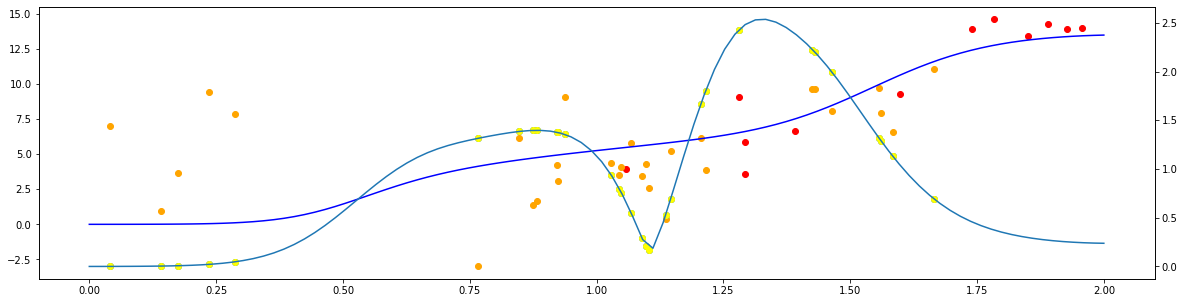

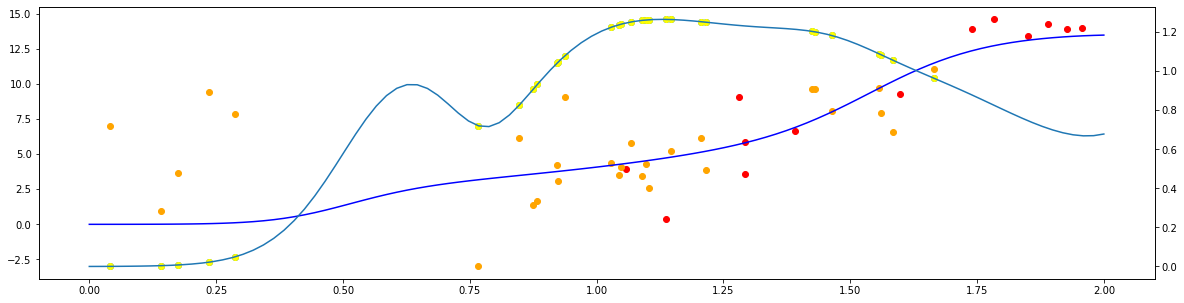

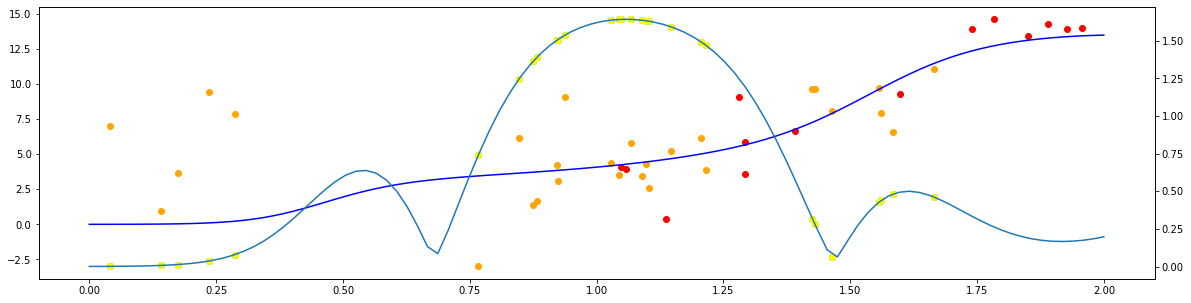

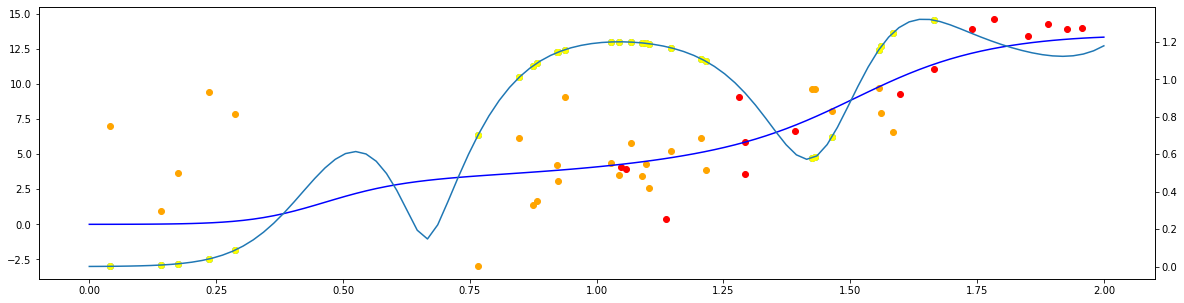

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform
from sklearn.gaussian_process import GaussianProcessRegressor
from skactiveml.regression._expected_model_change import ExpectedModelChange
from skactiveml.regression._expected_model_output_change import ExpectedModelOutputChange
from skactiveml.regression._expected_model_variance import ExpectedModelVarianceMinimization
from skactiveml.regression._greedy_sampling_x import GSx
from skactiveml.regression._greedy_sampling_y import GSy
from skactiveml.regression._kl_divergence_maximization import KullbackLeiblerDivergenceMaximization
from skactiveml.regression._mutual_information_maximization import MutualInformationGainMaximization
from skactiveml.regression._query_by_committee import QueryByCommittee
from skactiveml.regressor._wrapper import SklearnConditionalEstimator
from skactiveml.regressor.estimator._nichke import NormalInverseChiKernelEstimator
from skactiveml.utils import is_labeled, call_func
reg = SklearnConditionalEstimator(estimator=GaussianProcessRegressor())

# plot utilities
# active learning cycle for different query strategies

def true_function(X):
    x = X.flatten()
    return x**3 + 2*x**2 + x - 1

def noise_generator_provider(*intervals, std=1, default_std=0.5, random_state=None):
    # interval : tuple of shape (a, b) or (a, b, std), a < b,
    # where std is the standard deviation of the
    # gaussian noise in the interval [a, b)

    intervals = list(intervals)

    for idx, interval in enumerate(intervals):
        if len(interval) != 3:
            intervals[idx] = (*interval, std)

    def noise_generator(X):
        x = X.flatten()
        noise = np.zeros_like(x)
        for a, b, std_itv in intervals:
            noise_itv = norm.rvs(scale=std_itv, size=x.shape, random_state=random_state)
            noise = noise + np.where((a <= x) & (x < b), noise_itv, 0)
        noise += norm.rvs(scale=default_std, size=x.shape, random_state=random_state)
        return noise

    return noise_generator

def sample_generator_provider(*intervals, density=1, random_state=None):
    # interval : tuple of shape (a, b) or (a, b, density), a < b

    intervals = list(intervals)

    for idx, interval in enumerate(intervals):
        if len(interval) != 3:
            intervals[idx] = (*interval, density)

    def sample_generator(n_samples):
        total_weight = sum(((b-a)*density_itv for a, b, density_itv in intervals))
        interval_sizes = [int(n_samples*(b-a)*density_itv/total_weight)
                          for a, b, density_itv in intervals]
        currently_distributed = sum(interval_sizes)
        for i in range(n_samples - currently_distributed):
            interval_sizes[i] += 1
        X = np.zeros((0, 1))
        for size, (a, b, density_itv) in zip(interval_sizes, intervals):
            generated_samples = uniform.rvs(loc=a, scale=b-a, size=size, random_state=random_state)
            X = np.append(X, generated_samples)

        return X
    return sample_generator

x_low, x_up = 0, 2
random_state = 0
n_samples = 42
n_iterations = 15
noise_gen = noise_generator_provider((0, 1, 4), (1, 2), random_state=random_state)
sample_gen = sample_generator_provider((x_low, x_up, 20), (0.5, 1.5, 20), random_state=random_state)
X = np.sort(sample_gen(n_samples)).reshape(-1, 1)
X_test = np.linspace(x_low, x_up, num=100).reshape(-1, 1)

qs_s = [
    #GSx(random_state=random_state);
    #GSy(random_state=random_state),
    #ExpectedModelChange(random_state=random_state)
    QueryByCommittee(random_state=random_state)
    #ExpectedModelVarianceMinimization(random_state=random_state),
    #ExpectedModelOutputChange(random_state=random_state),
    #KullbackLeiblerDivergenceMaximization(random_state=random_state,
    #                                      integration_dict_cross_entropy={'method':'monte_carlo',
    #                                                                      'n_monte_carlo':240})
    #MutualInformationGainMaximization(random_state=random_state),
]


y_true = true_function(X) + noise_gen(X)

plt.scatter(X, y_true)
plt.plot(X, true_function(X))
plt.show()

y = np.full_like(y_true, np.nan)
y_s = [y.copy() for _ in range(len(qs_s))]

cond_est = NormalInverseChiKernelEstimator(metric_dict={'gamma': 10.0})

for i in range(n_iterations):
    fig, axes = plt.subplots(1, len(qs_s), figsize=(20, 5))
    axes = axes if isinstance(axes, tuple) else (axes,)
    for qs, ax, y in zip(qs_s, axes, y_s):
        indices, util = call_func(qs.query,
            X=X,
            y=y,
            cond_est=cond_est,
            reg=cond_est,
            ensemble=cond_est,
            fit_cond_est=True,
            return_utilities=True
        )
        _, util_2 = call_func(qs.query,
            X=X,
            y=y,
            cond_est=cond_est,
            reg=cond_est,
            ensemble=cond_est,
            fit_cond_est=True,
            candidates=X[~is_labeled(y)],
            return_utilities=True
        )
        _, utilities_test = call_func(qs.query,
            X=X,
            y=y,
            cond_est=cond_est,
            reg=cond_est,
            ensemble=cond_est,
            candidates=X_test,
            fit_cond_est=True,
            return_utilities=True,
        )
        y_old = y.copy()
        y[indices] = y_true[indices]
        is_lbld = is_labeled(y)
        ax_t = ax.twinx()
        ax_t.plot(X_test, utilities_test.flatten())
        ax_t.scatter(X, util.flatten())
        ax_t.scatter(X[~is_labeled(y_old)].flatten(), util_2.flatten(), c='yellow')

        ax.scatter(X[is_lbld], y[is_lbld], c='red')
        ax.scatter(X[~is_lbld], y_true[~is_lbld], c='orange')

        cond_est.fit(X, y)
        y_pred, y_std = cond_est.predict(X_test, return_std=True)
        ax.plot(X_test, y_pred, c='blue')
    plt.show()
